In [45]:
from IPython.display import HTML
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, Image
import gc
# import matplotlib
# matplotlib.use('Agg')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import datetime
import numpy as np
import pickle
import util
from multiprocessing import Process
import sys
import RPi.GPIO as GPIO
GPIO.setwarnings(False)

from util import *

proc = None
temps = collections.deque(maxlen=144)
message_log = collections.deque(maxlen=200)

In [46]:
144/((24*60)/12)


1.2

In [47]:
# temp_ini()
# read_temp()

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [191]:
temp_ini()
wireless_ini()


def radiator_controller(temp_lower, time_finish, interval_load):
    """
    Reads temperature, appends to limited width buffer which is writen to a txt file.
    Also plots a graph should another process wish to view the graph
    There is a delta of the temperature_min, where it does nothing.
    """
    while True:
        file_log = open('log.txt','w')
        t = datetime.datetime.now()
        tot_m, used_m, free_m = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])
        curr = read_temp()
        temps.append((t, curr))
        if (curr <= temp_lower) & (t.hour < time_finish):
            message = 'date:%d %d:%d:%d Temp: %.3f, turning on the radiator. PARAM:ideal_temp %s end_time %d int%d'%(t.day, t.hour, t.minute,t.second, curr, temp_lower, time_finish, interval_load)
            message_log.appendleft(message)
            wireless_one()
#             print('trigger ', curr, time_finish, t.hour)
            sys.stdout.write("%s  \r" % (message) )
            sys.stdout.flush()

        elif (curr > (temp_lower + 0.2)) or (t.hour > time_finish):
            message = 'date:%d %d:%d:%d Temp: %.3f, turning OFF radiator. PARAM:ideal_temp %s end_time %d int%d free_mem%d'%(t.day, t.hour, t.minute,t.second, curr, temp_lower, time_finish, interval_load,free_m)
            message_log.appendleft(message)
            wireless_one_off()
#             print('OFF ', curr, time_finish, t.hour)
            sys.stdout.write("%s  \r" % (message) )
            sys.stdout.flush()

        else:
            message = 'date:%d %d:%d:%d Temp:%.3f . PARAM:ideal_temp %s end_time %d int%d'%(t.day, t.hour, t.minute,t.second, curr, temp_lower, time_finish, interval_load)
            message_log.appendleft(message)
            sys.stdout.write("%s  \r" % (message) )
            sys.stdout.flush()

        file_log = open('log.txt','w')
        file_log.write("\n <br />".join(message_log))
        file_log.close()
#         plt.plot([i[1] for i in temps])
        d = pd.Series(index = [i[0] for i in temps], data = [i[1] for i in temps])#.plot(figsize=(20,7))
#         fig=plt.figure()
#         ax = fig.add
#         
#         plt.figure()
#         plt.plot()
        fig, ax=plt.subplots(figsize=(20,7))
        ax.plot(d)
#         sns.lineplot(data = d, style = 'event', ci = 'sd', err_style='band', ax=ax)
#         _ = plt.xticks(rotation = 30)
        plt.savefig('graph.png')
#         plt.show()
#         plt.show(block=False)
        plt.close(fig)
        plt.close('all')
        plt.close()
        plt.clf()
        plt.cla()
        if t.hour > time_finish:
            time.sleep(interval_load*1)
        else:
            time.sleep(interval_load)
#         %reset
        del ax
        del fig
        del d
        gc.collect()

In [192]:
def time_return(end_am_time):
    return end_am_time
def temp_return(opt_temp):
    return opt_temp
def interval_return(min_interval):
    return min_interval
end_temp = interact(temp_return, opt_temp=widgets.FloatSlider(min=12,max=20,step=0.5,value=16.7));
end_time = interact(time_return, end_am_time=widgets.FloatSlider(min=0,max=24,step=1,value=8));
end_interval = interact(interval_return, min_interval=widgets.FloatSlider(min=1,max=1200,step=1,value=5));

interactive(children=(FloatSlider(value=16.7, description='opt_temp', max=20.0, min=12.0, step=0.5), Output())…

interactive(children=(FloatSlider(value=8.0, description='end_am_time', max=24.0, step=1.0), Output()), _dom_c…

interactive(children=(FloatSlider(value=5.0, description='min_interval', max=1200.0, min=1.0, step=1.0), Outpu…

In [193]:
temp = end_temp.widget.kwargs['opt_temp']
time_load = end_time.widget.kwargs['end_am_time']
interval_load = end_interval.widget.kwargs['min_interval']
print('Maintaining temp: ',temp)
print('Will do this for hour less than:', time_load)
print("will check every:   min", interval_load/60)

Maintaining temp:  16.7
Will do this for hour less than: 8.0
will check every:   min 0.08333333333333333


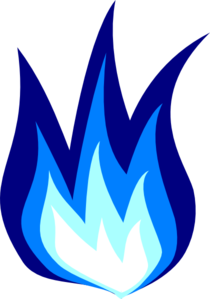

/home/pi/.local/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Process Process-26:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-191-c12d9049432c>", line 14, in radiator_controller
    tot_m, used_m, free_m = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])
  File "/usr/lib/python3.5/os.py", line 1035, in popen
    bufsize=buffering)
  File "/usr/lib/python3.5/subprocess.py", line 676, in __init__
    restore_signals, start_new_session)
  File "/usr/lib/python3.5/subprocess.py", line 1221, in _execute_child
    restore_signals, start_new_session, preexec_fn)
OSError: [Errno 12] Cannot allocate memory


In [194]:
display(Image(filename='blue-fire-md.png'))
proc = Process(target=radiator_controller, args=(temp,time_load, interval_load))
proc.start()

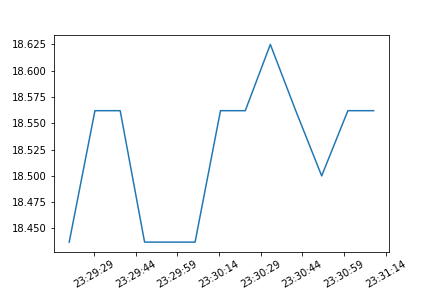

In [174]:
Image('graph.png')

In [167]:
proc.is_alive()

False

In [19]:
off_button = widgets.Button(description = 'Turn Off Radiator')
display(off_button)
def off_button_clicked(b):
    print('Off Button Clicked, turning off heater')
    util.wireless_one_off()
    if proc is not None:
        if proc.is_alive():
            print('its killing time')
            proc.terminate()

off_button.on_click(off_button_clicked)

##########################################################
on_button = widgets.Button(description = 'Turn On Radiator')
display(on_button)
def on_button_clicked(b):

    print('On Button Clicked, turning On heater')
    util.wireless_one()

on_button.on_click(on_button_clicked)

##########################################################
##########################################################

##########################################################
control_off_button = widgets.Button(description = 'controller OFF')
display(control_off_button)
def control_off_button_clicked(b):
    print('Control Off Button Clicked, turning off heater control')
    util.wireless_one_off()
    if proc is not None:
        if proc.is_alive():
            print('its killing time')
            proc.terminate()

control_off_button.on_click(control_off_button_clicked)

Button(description='Turn Off Radiator', style=ButtonStyle())

Button(description='Turn On Radiator', style=ButtonStyle())

Button(description='controller OFF', style=ButtonStyle())

Control Off Button Clicked, turning off heater control
its killing time
On Button Clicked, turning On heater
Off Button Clicked, turning off heater
Control Off Button Clicked, turning off heater control
its killing time
On Button Clicked, turning On heater
Off Button Clicked, turning off heater
Control Off Button Clicked, turning off heater control
Control Off Button Clicked, turning off heater control
its killing time
On Button Clicked, turning On heater
Control Off Button Clicked, turning off heater control


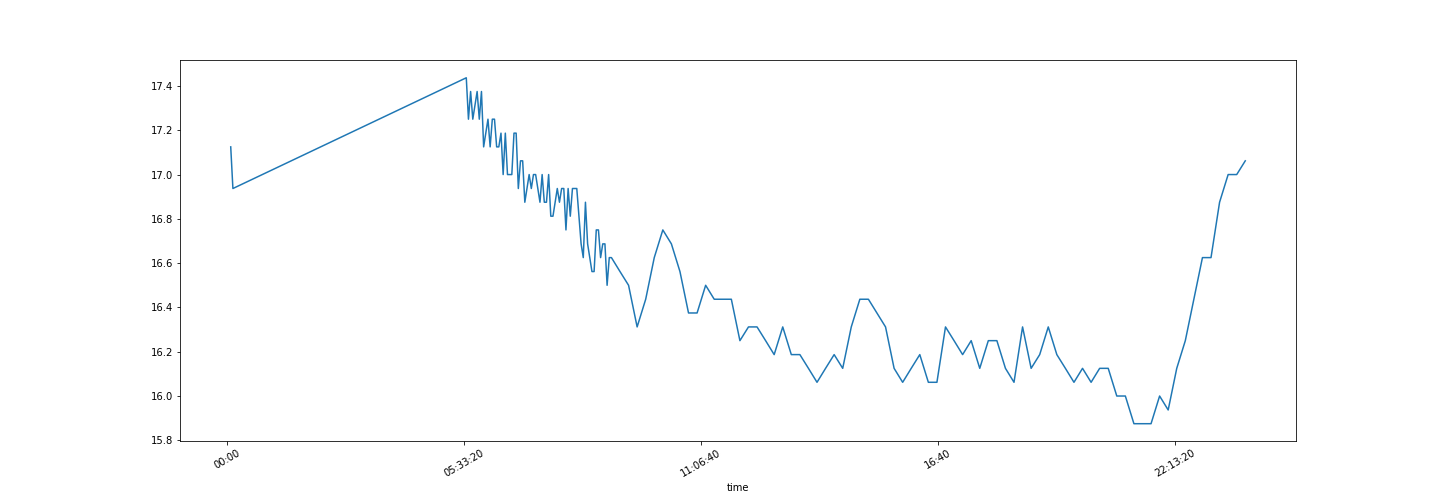

In [49]:
try:
    display(Image(filename='graph.png') )
except:
    print('try again')

In [10]:
# proc.terminate()

In [3]:
# radiator_controller(temp_lower=15, time_finish=8)

In [87]:
# def f(a, b):
#     display(a + b)
#     return a+b

# global w
# w = interactive(f, a=10, b=20)
# display(w)

In [8]:
# def printer():
#     while True:
#         print(w.kwargs.values())
#         time.sleep(1)
# # printer()

In [10]:
# import threading
# t = threading.Thread(target = printer)

In [7]:
# def test_func():
#     while True:
# #         print(time.time())
# #         print('%f \r'%time.time(), end = '')
#         sys.stdout.write("time: %f  \r" % (time.time()) )
#         sys.stdout.flush()
#         time.sleep(1)

# # test_func()

In [23]:
# def runner():
#     proc = Process(target = test_func)
#     proc.start()
#     return proc
# p = runner()

In [15]:
# # global proc
# global proc_list
# proc_list = []

# on_button_control = widgets.Button(description = 'controller ON')
# display(on_button_control)
# def on_button_control_clicked(b):
#     print('Control On Button Clicked, turning On heater Control')
# #     proc = Process(target = radiator_controller(temp_lower=15, time_finish=8))
#     proc = Process(target = test_func)
#     proc_list.append(proc)
# #     proc.start()
#     print('process started')
# #     return proc

# on_button_control.on_click(on_button_control_clicked)





In [16]:
# control_off = False
# radiator_controller(temp_lower=15, time_finish=8)

In [6]:
# temp_required = interact(x = 15)

In [17]:
# import sys
# print(sys.executable)
# print(sys.version)

In [2]:
# import base64

In [3]:
# import collections
# d = collections.deque(maxlen=10)

In [18]:
# plt.plot([0,0,0,0])

In [19]:
# import matplotlib.pyplot as plt 
# import os
# os.getcwd()

In [23]:
import RPi.GPIO as GPIO
import time
import os
import datetime
import numpy as np
# import seaborn as sns
import pickle
# GPIO.setwarnings(False)

In [24]:
# !pip install seaborn

In [25]:
# !sudo dtoverlay w1-gpio gpiopin=6 pullup=0 # header pin 7

In [26]:
def wireless_ini():
#     GPIO.cleanup()
    # set the pins numbering mode
    GPIO.setmode(GPIO.BOARD)
    # Select the GPIO pins used for the encoder K0-K3 data inputs
    GPIO.setup(11, GPIO.OUT)
    GPIO.setup(15, GPIO.OUT)
    GPIO.setup(16, GPIO.OUT)
    GPIO.setup(13, GPIO.OUT)
    # Select the signal used to select ASK/FSK
    GPIO.setup(18, GPIO.OUT)
    # Select the signal used to enable/disable the modulator
    GPIO.setup(22, GPIO.OUT)
    # Disable the modulator by setting CE pin lo
    GPIO.output (22, False)
    # Set the modulator to ASK for On Off Keying
    # by setting MODSEL pin lo
    GPIO.output (18, False)
    # Initialise K0-K3 inputs of the encoder to 0000
    GPIO.output (11, False)
    GPIO.output (15, False)
    GPIO.output (16, False)
    GPIO.output (13, False)
    
def wireless_one():
    print('turning on radiator')
    GPIO.output (11, True)
    GPIO.output (15, True)
    GPIO.output (16, True)
    GPIO.output (13, True)
    # let it settle, encoder requires this
    time.sleep(0.1)
    # Enable the modulator
    GPIO.output (22, True)
    # keep enabled for a period
    time.sleep(0.25)
    # Disable the modulator
    GPIO.output (22, False)
#     GPIO.cleanup()

In [27]:
def wireless_one_off():
    print ("sending code 0111 Socket 1 off")
    GPIO.output (11, True)
    GPIO.output (15, True)
    GPIO.output (16, True)
    GPIO.output (13, False)
    # let it settle, encoder requires this
    time.sleep(0.1)
    # Enable the modulator
    GPIO.output (22, True)
    # keep enabled for a period
    time.sleep(0.25)
    # Disable the modulator
    GPIO.output (22, False)
#     GPIO.cleanup()

In [56]:
# wireless_ini()
wireless_one()


turning on radiator


In [32]:
temp_loc = '/sys/bus/w1/devices/'
device = '28-0213924576ef/'

In [51]:
def temp_ini():
    GPIO.cleanup()
    GPIO.setmode(GPIO.BOARD)
    GPIO.setup(40, GPIO.OUT) #21 BCM
    GPIO.output(40,1)

    os.system('modprobe w1-gpio')
    os.system('modprobe w1-therm')

#     temp_loc = '/sys/bus/w1/devices/'
    #########
#     os.chdir(temp_loc)
#     print(os.listdir())
##############
#     device = '28-0213924576ef/'
#     os.chdir(temp_loc+device)
#     print(os.getcwd())
    
temp_ini()    

In [52]:
def temp_raw():
    temp_sensor = temp_loc+device+'w1_slave'
    f=open(temp_sensor,'r')
    lines = f.readlines()
    f.close()
    return lines

def read_temp():
#     temp_ini()
    lines=temp_raw()
    while lines[0].strip()[-3:]!='YES':
        time.sleep(0.1)
        try:
            lines = temp_raw()
        except:
            print('temp read fail')
    temp_output = lines[1].find('t=')
    if temp_output != -1:
        temp_string = lines[1].strip()[temp_output+2:]
        temp_c = float(temp_string)/1000.0
        return temp_c
    

In [22]:
# temps = []
# trigger_block = False
# block_time = datetime.datetime.now().time() #ini
# t = datetime.datetime.now().time()
# print('entering loop')
# while True:
#     t = datetime.datetime.now().time()
#     curr = read_temp()
#     print(t, curr)
#     temps = temps + [(t,curr)]
    
#     if (curr <= 17.0)  & (t.hour < 9) & (trigger_block == False):
#         trigger_block = True  
#         wireless_ini()
#         wireless_one()
#     elif (curr>17.5)& (trigger_block == True):
#         wireless_ini()
#         wireless_one_off()
#         trigger_block = False
    
#     time.sleep(60)

In [27]:
temps = []

In [29]:
temps = temps + [1]

In [67]:
import matplotlib.pyplot as plt 

In [116]:
te = [i[1] for i in temps]

In [72]:
ti = [i[0] for i in temps]

In [76]:
import matplotlib.dates as dates

In [92]:
my_day = datetime.date(2019, 1, 5)
x_dt = [ dates.date2num(datetime.datetime.combine(my_day, t)) for t in ti ]

In [23]:
# plt.plot(te)
# plt.annotate('17.0 heater activation',xy = (120,17), xytext = (100, 16.8),arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('17.5 heater cutt-off',xy = (370,17.5), xytext = (400, 17.65),arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('9am heater cutt-off',xy = (448,17.0), xytext = (350, 16.65),arrowprops=dict(facecolor='black', shrink=0.05))
# plt.xlim(0,600)
# plt.show()

In [24]:
# plt.plot(x_dt, te)
# plt.gcf().autofmt_xdate()
# plt.show()

In [25]:
# !sudo touch 190104to05temp_data.pkl

# pickle.dump(temps,open('190104to05temp_data.pkl', 'wb'))

In [6]:
from flask import Flask
from flask_ask import Ask, statement, convert_errors
import RPi.GPIO as GPIO
import logging
import serial
import time

In [26]:
# app = Flask(__name__)

# ask = Ask(app, '/')

# logging.getLogger("flask_ask").setLevel(logging.DEBUG)

# @ask.intent('temperature')

# def temperature():
#     x = 20
# #   x = 'The temperature is %d'%read_temp()

#     return statement(x)


# app.run(host='0.0.0.0', port=8080, debug=True)

In [11]:
def web_page(im_tag): 
    page= """

    <html>
    <head>
    <style>
    body {
            color: red;
    }
    </style>
    <body bgcolor="#000000">
        <head>
            <title>Temperature Plot</title>
        </head>
        <body>
            <h1>"""+ str_format()+""" </h1> 
            """ + im_tag + """
            
        </body>
    </html>


    """
    return page

In [12]:
def str_format():
    t = datetime.datetime.now().time()
    return "The time is %d:%d and the temperature is...  %d degrees"%(t.hour, t.minute, read_temp())

In [13]:
from flask import Flask
app = Flask(__name__)

@app.route('/')
def hello_world():
    data_uri = base64.b64encode(open('graph.png', 'rb').read()).decode('utf-8').replace('\n', '')
    img_tag = '<img src="data:image/png;base64,{0}">'.format(data_uri)
    return web_page(img_tag) #str_format()

app.run(host='0.0.0.0', port=8080)

 * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)


In [27]:
# plt.plot([1,2,3], [2,3,3])
# plt.savefig('graph.png')

In [7]:
exposed_page = """
<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {
        "762b489fb1574f1dac36ebb17cbd7ef6": {
            "model_name": "LayoutModel",
            "model_module": "@jupyter-widgets/base",
            "model_module_version": "1.1.0",
            "state": {}
        },
        "413580ba7d2649ba9520725ded2d7b8a": {
            "model_name": "ButtonStyleModel",
            "model_module": "@jupyter-widgets/controls",
            "model_module_version": "1.4.0",
            "state": {}
        },
        "cff2c1b5d4ee490eae5e4fa758345d22": {
            "model_name": "ButtonModel",
            "model_module": "@jupyter-widgets/controls",
            "model_module_version": "1.4.0",
            "state": {
                "style": "IPY_MODEL_413580ba7d2649ba9520725ded2d7b8a",
                "description": "Off",
                "layout": "IPY_MODEL_762b489fb1574f1dac36ebb17cbd7ef6"
            }
        },
        "29c4bc6d5328415881125d2a4815eae6": {
            "model_name": "LayoutModel",
            "model_module": "@jupyter-widgets/base",
            "model_module_version": "1.1.0",
            "state": {}
        },
        "271431dd902742a288396c08c5b5108b": {
            "model_name": "ButtonStyleModel",
            "model_module": "@jupyter-widgets/controls",
            "model_module_version": "1.4.0",
            "state": {}
        },
        "c0e3eb3812114a25b7260182b618ee18": {
            "model_name": "ButtonModel",
            "model_module": "@jupyter-widgets/controls",
            "model_module_version": "1.4.0",
            "state": {
                "style": "IPY_MODEL_271431dd902742a288396c08c5b5108b",
                "description": "On",
                "layout": "IPY_MODEL_29c4bc6d5328415881125d2a4815eae6"
            }
        }
    }
}
</script>
</head>
<body>

<script type="application/vnd.jupyter.widget-view+json">
{
    "version_major": 2,
    "version_minor": 0,
    "model_id": "cff2c1b5d4ee490eae5e4fa758345d22"
}
</script>

<script type="application/vnd.jupyter.widget-view+json">
{
    "version_major": 2,
    "version_minor": 0,
    "model_id": "c0e3eb3812114a25b7260182b618ee18"
}
</script>

</body>
</html>
"""

In [28]:
# from flask import Flask
# app = Flask(__name__)

# @app.route('/')
# def hello_world():

#     return exposed_page

# app.run(host='0.0.0.0', port=8070)

In [10]:
np.random.rand()

0.8586693261470723

In [14]:
te = [(datetime.datetime.now().time(), np.random.rand()) for i in range(10)]

In [15]:
import seaborn

In [16]:
x=[i[1] for i in te]
x

[0.3474774081958595,
 0.14097976109218602,
 0.9688285031746463,
 0.37791815050863564,
 0.025238096582951952,
 0.8542634459974617,
 0.4944872814083475,
 0.07255947629726078,
 0.7467248169586597,
 0.6956299044676814]

In [17]:
y = [i[0] for i in te]
y

[datetime.time(0, 20, 8, 770369),
 datetime.time(0, 20, 8, 776897),
 datetime.time(0, 20, 8, 777043),
 datetime.time(0, 20, 8, 777135),
 datetime.time(0, 20, 8, 777222),
 datetime.time(0, 20, 8, 777311),
 datetime.time(0, 20, 8, 777392),
 datetime.time(0, 20, 8, 777474),
 datetime.time(0, 20, 8, 777557),
 datetime.time(0, 20, 8, 777640)]

In [20]:
d = pd.Series(index = y, data = x)

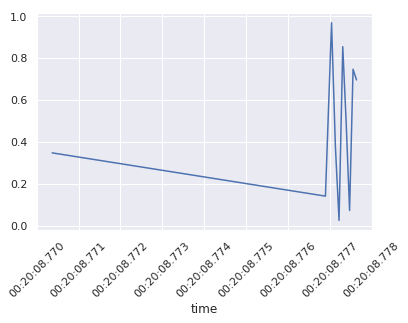

In [44]:
sns.set(style="darkgrid")
g = sns.lineplot(data = d, style = 'event', ci = 'sd', err_style='band')
# g.set_xticklabels(rotation=30)
_ =plt.xticks(rotation=45)


In [49]:
datetime.datetime.now().time()pd.Timedelta('1day')

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'Timedelta'

In [46]:
pd.Timedelta('1day')

Timedelta('1 days 00:00:00')

In [ ]:
plt.ylim()

AttributeError: Unknown property rotate

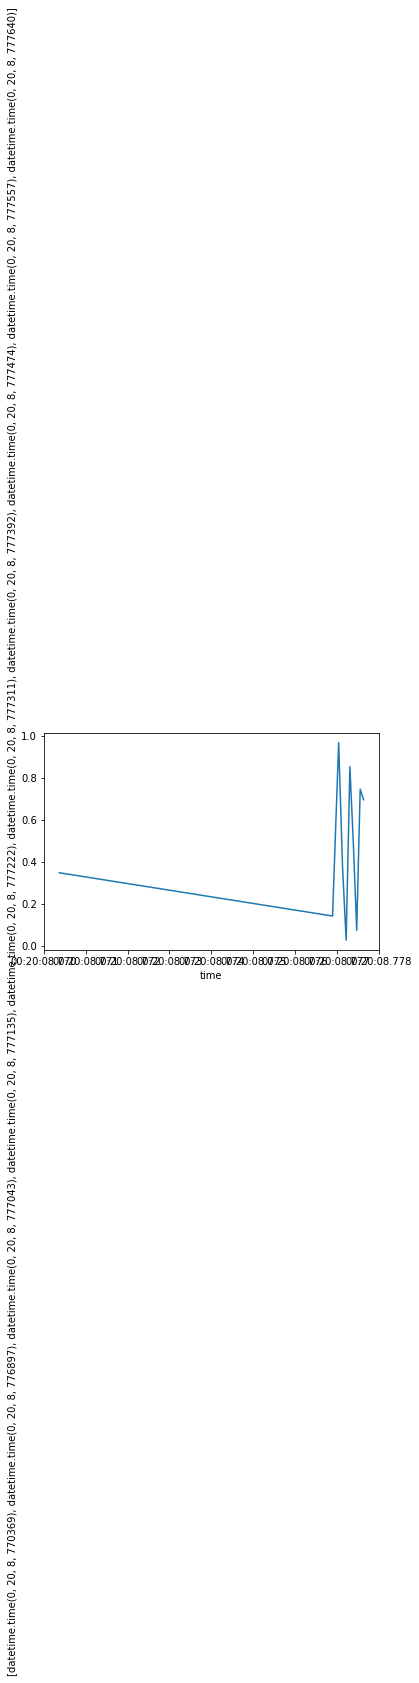

In [22]:
plt.plot(d)
plt.ylabel(y, rotate=90)